----
# Logistic Regression
----
### Summary:
Using the MNIST Sign Language Dataset to build a basic Logistic Regression Classification model which will act as a baseline model.

### Data Overview:
- **Dataset**: MNIST Sign Language Dataset
- **Number of Samples**: Approximately 1400 images per character
- **Image Dimensions**: Each image consists of 784 pixel values (28x28 pixels flattened into a 1D array)

### Notebook Overview:
- **Data Loading**:
   - Load the MNIST Sign Language dataset.
   - Split the data into training and validation sets.

- **Data Visualisation**:
   - Visualising single image for each letter as well as the mean of all images for each letter.
   - Exploring effects of thresholding.

- **Building the Logistic Regression Model**:
   - Build a Logistic Regression model.
   - Train the model using the training dataset.

- **Model Evaluation**:
   - Assess the accuracy of the model on the validation dataset.
   - Analyse the model's performance using a confusion matrix and visualise misclassifications.
   - Explore odds ratio for each letter to unpack what the model has learnt about a given letter.


## Set Up
---

In [1]:
# List of imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math
import joblib


## Data Loading
---

In [2]:
X  = joblib.load( '../../data/my_data/X.pkl' )
y = joblib.load( '../../data/my_data/y.pkl' )

In [3]:
# Both to be used at a later time to assign meaningful values to the nuermic target class
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']

In [4]:
# To store unique class values - to be used later in loops
unique_values, value_counts = np.unique(y, return_counts=True)

## Utility Functions
---


In [5]:
def assess_coef(coef, letter='a'):
    '''
    Overview:
    Plots the mean image of a given letter and the odds ratio image based on model coefficients.

    Arguments:
        - coef -> Model coefficients for all letters/classes
        - letter -> Letter (NOT J/Z as both of these letters do not exist in dataset)

    Output:
        - 2 figures:
            -  mean image of given letter
            - 'odds ratio' pixel image for each given letter

    '''
    # Data set contains no data for letters j and z, to raise error message if input letter is j/z
    if letter.lower() in ('j', 'z'):
        raise ValueError("The input letter cannot be 'j' or 'z'.")
    else:

        my_image = X.reshape(-1,28,28)
        my_class = y

        fig, axes = plt.subplots(1,2, figsize=(20, 10))

        # get index of letter as class is int data type
        idx1 = alphabet.index(letter.lower())

        plt.subplot(1,2,1)
        plt.imshow(np.mean(my_image[my_class==idx1], axis = 0) ,cmap='gray')
        plt.title(f'Mean of {letter.upper()}',fontsize='50')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,2,2)
        # Using cmap show the odds ratio -> cases where odds ratio is > 1 means certain pixel increases the odss of the image being classified as the target letter
        #                                -> cases where odds ratio is < 1 means certain pixel decreses the odds of the image being classified as the target letter
        plt.imshow(np.exp(coef[idx1]).reshape(28,28),cmap='BuPu')
        # added positioning to make colour bar same height as image
        plt.colorbar(label='Odds Ratio',fraction=0.046, pad=0.04)
        plt.title(f'Odds Ratio for {letter.upper()}',fontsize='50')
        plt.xticks([])
        plt.yticks([])

        plt.tight_layout()
        plt.show()

## Data Visualisation
----

In [6]:
my_image = X.reshape(-1,28,28)
my_class = y

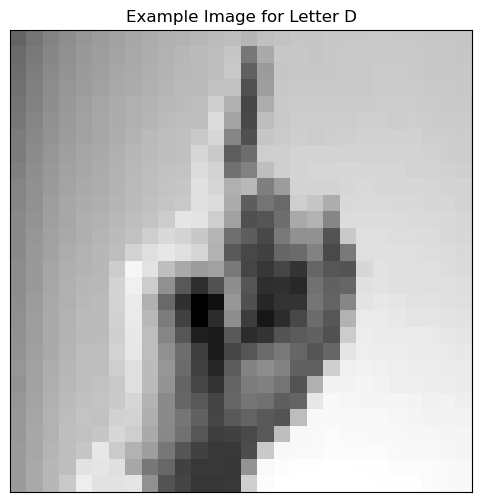

In [7]:
# To show a single image example usinf plt.imshow
plt.figure(figsize=(6, 6))
# Using cmap to convert colours to greyscale -> coloured image doesn't seem to provide any additional details
plt.imshow(my_image[0], cmap="gray")
plt.title(f'Example Image for Letter {alphabet[my_class[0]].upper()}')
plt.xticks([])
plt.yticks([])
plt.show()

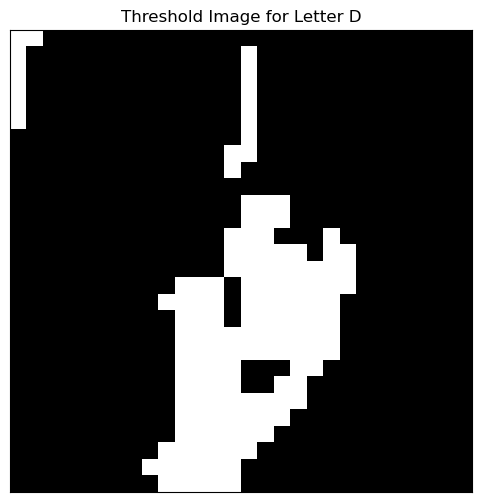

In [8]:
# Applying thresholding using np.where to force pixel intensity to 0 (black) for cases where pixel intensity is greater than 180
normalised = np.where(my_image[0] > 120,0,1)
plt.figure(figsize=(6, 6))
plt.imshow(normalised, cmap="gray")
plt.title(f'Threshold Image for Letter {alphabet[my_class[0]].upper()}')
plt.xticks([])
plt.yticks([])
plt.show()

**Comments**:

To me, thresholding doesn't look like it would be helpful for this dataset.

If I look below, there is varying pixel intensity inside the hand therfore only using two colours black and white will not help this model. A strict thresholding to black and white will most likely confuse the model as there are subtle differences between some letters which is harder to capture if we use thresholding. For example:

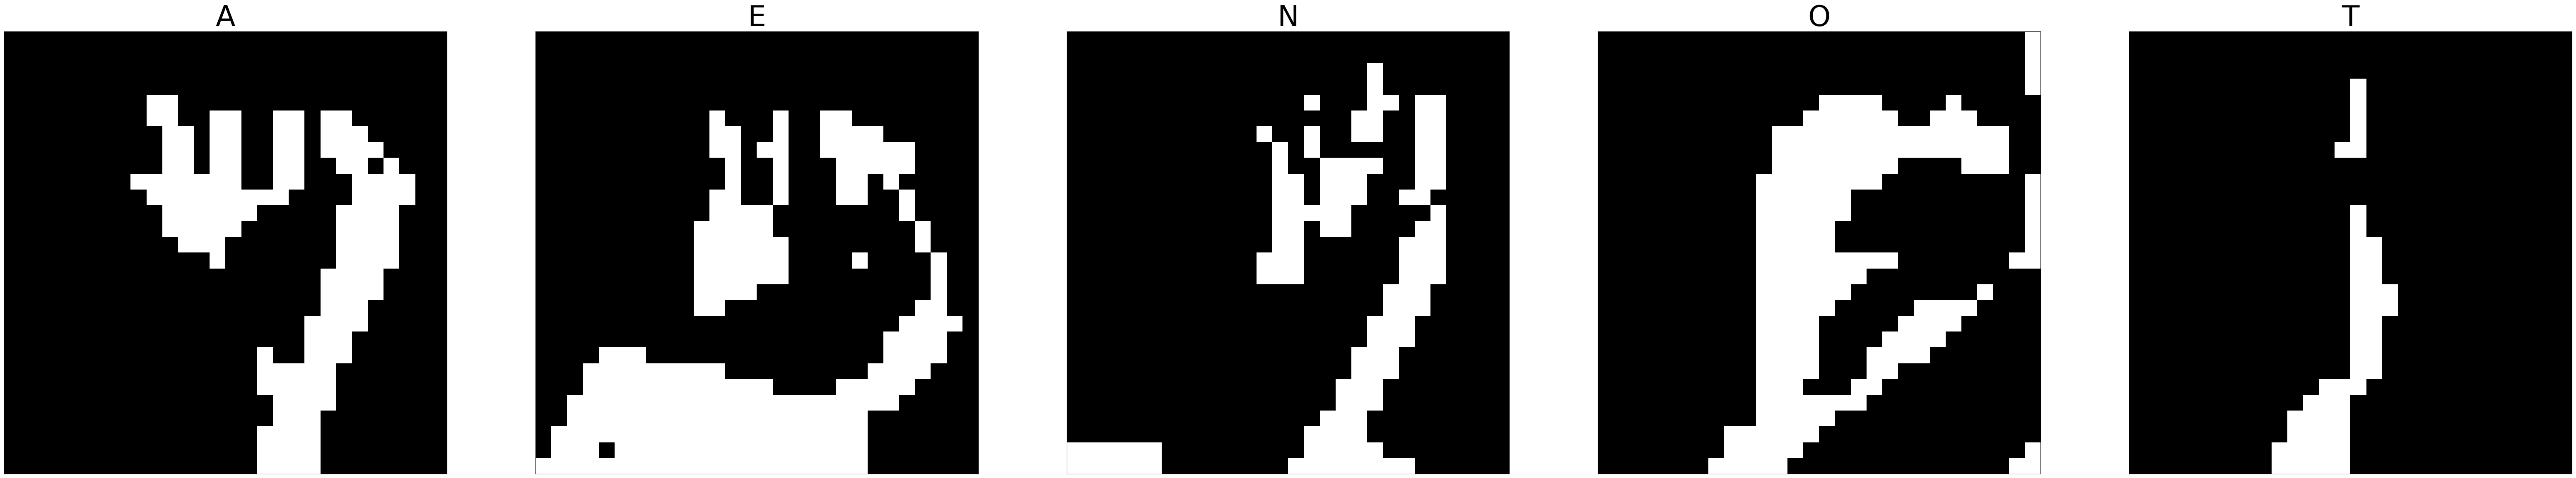

In [9]:
# creating a subplot canvas with 1 row and 5 plots, each plot has figure size 80 120
fig, axes = plt.subplots(1,5, figsize=(80, 120))
# grabbing examples of letters where the sign is similar
ae_idx = [0,4,12,13,18]

# using zip to combine the index of my ae_idx (target) and is corresponding plot position (ax) into a tuple
for target, ax in zip(ae_idx, axes.ravel()):
    # Passing in [my_class == target] to my image -> filters images to only retrieve images where the label is in ae_idx list ^
    # [0] to retrieve only the first image for each letter
    normalised = np.where(my_image[my_class==target][0] > 120,0,1)
    ax.imshow(normalised, cmap = 'gray')
    # using alphabet array and target as an index to set the title for each subplot
    ax.set_title(alphabet[target].upper(),fontsize=50)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


### Assessing the Images


##### Printing a single image for each character:

In [10]:
fig, axes = plt.subplots(6,4, figsize=(80, 120))

for target, ax in zip(unique_values, axes.ravel()):
    ax.imshow(my_image[my_class==target][0], cmap = 'gray')
    ax.set_title(alphabet[target].upper(),fontsize=50)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

##### Printing mean image for each character:
This allows us to assess what features(pixels) the model are most likely to "see" as the most defining for each class. We will revisit this later when we assess the performance of the Logistic Model.

In [11]:
fig, axes = plt.subplots(6, 4, figsize=(80, 120))
for target, ax in zip(unique_values, axes.ravel()):
    # calculating the mean of each class along the rows
    #myimage[my_class == target] has shape (~1400, 784) so we calculate mean pixel value for each of the 784 pixels across all ~1400 instances
    ax.imshow(np.mean(my_image[my_class==target], axis = 0), cmap = 'gray')
    ax.set_title(alphabet[target].upper(),fontsize=50)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## Building the Logistic Regression Model
---

In [12]:
my_image = X.reshape(-1,28,28)
my_class = y

In [13]:
# Flattening each image back to 784 pixels for the Logistic Regression model
flattened_dataset = my_image.reshape(my_image.shape[0],28 * 28)

In [14]:
X = flattened_dataset

# Splitting my dataset into train and test datasets (80% = train/20%= test)
# Setting random state to allow replciation of "random" numbers
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1, stratify= y)

In [15]:
# Using saga algorithm with lasso penalty, saga algorithm works best for larger datasets, alpha set to to 0.01
my_model = LogisticRegression(solver='saga', penalty='l1', C=1, max_iter=1000)

my_model.fit(X_train, y_train)

/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

**Comment:**

Still seeing warinings that the model did not converge- I have tried to increase the number of max iters to 1500 and got the same results with a very long time.

I assumed this may be as I have not scaled my X features so I tried to run the model with scaled X which seemed to fix the issue, however when I was plotting the odds ratio they were no longer clear as they are when the params were like above.

If I had more time I would play around with the scaling and different params to see if I can get better results however as this is just my preliminary model I will be moving forward with other approaches with a note to revisit this at a later date.

In [16]:
print(f'train score: {my_model.score(X_train, y_train)}')
print(f'val_score:{my_model.score(X_val,y_val)}')

train score: 0.9999639002202086
val_score:0.9998556165174703



**Comment:**
Difference between the train and test score is very low (0.0005), suggesting a good, robust model.


In [17]:
joblib.dump(my_model, '../../model/my_models/log_reg_basic_model.pkl')

['../../model/my_models/log_reg_basic_model.pkl']

## Model Evaluation
----

### Confusion Matrix:
Plotting a confusion matrix shows us the number of correctly and incorrecly classified images of the model.Since performance of the final model (my_model2) is very high we see a low number of misclassifications.

In [18]:
my_final_model = joblib.load('../../model/my_models/log_reg_basic_model.pkl')

In [19]:
pred_y = my_model.predict(X_val)

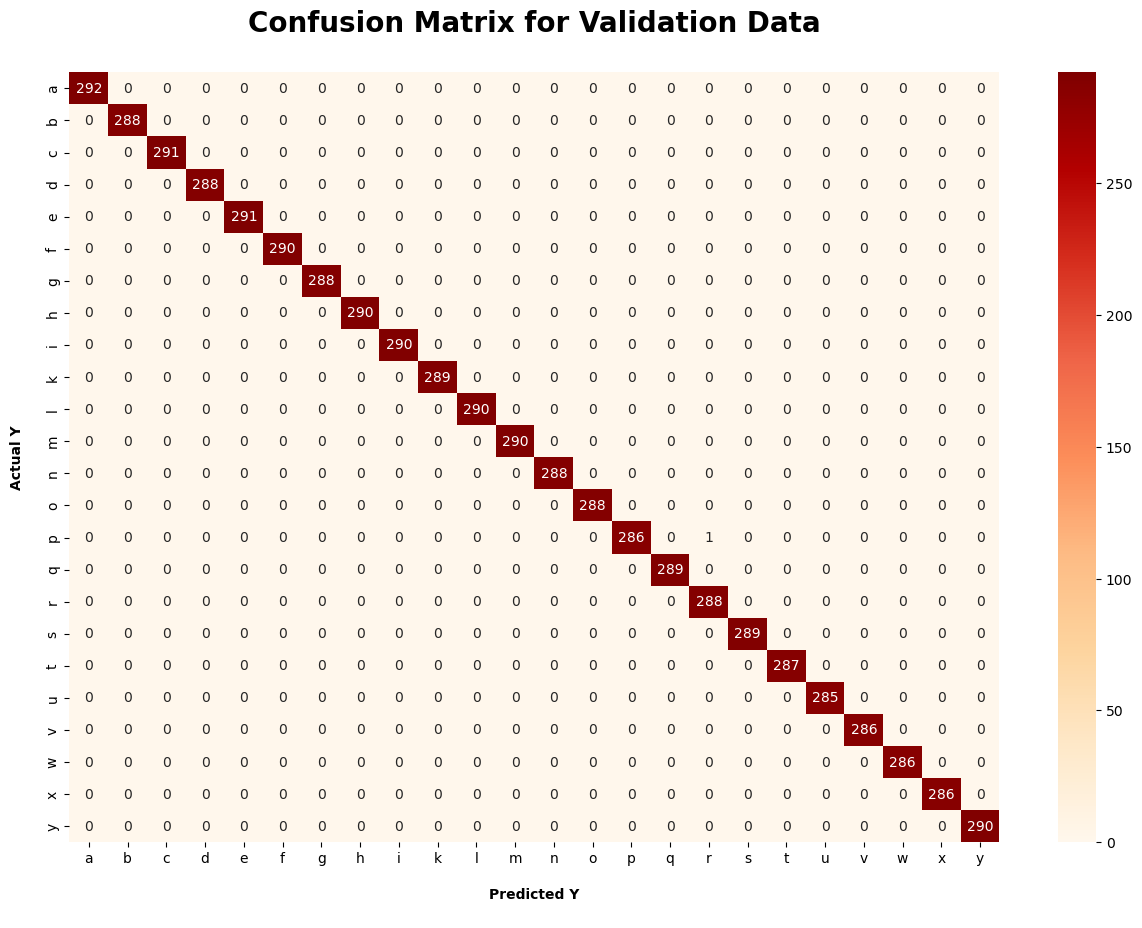

In [40]:
# Calculating the confusion matrix using sklearn.metrics
conf_matrix = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))

# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Validation Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

**Assessment of Accuracy:**
The final model shows us a very high accuracy for both training and test data, it would be interesting to see what pixels (features) are the most defining for each letter when it comes to classification. To do this, I will assess the coefficients of the logistic models for each letter.

### Visualising Misclassifications

In [21]:
incorrect_photos = (y_val != pred_y)

In [22]:
X_val = X_val.reshape(-1,28,28)

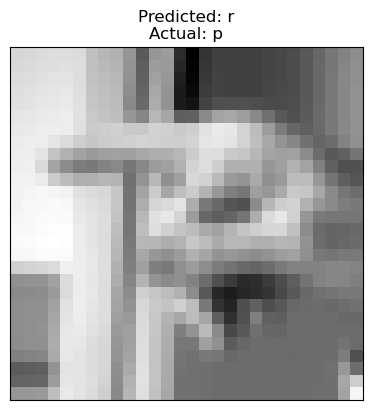

In [23]:
num_photos = incorrect_photos.sum()
rows = math.ceil(num_photos / 5)

fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))

for i, ax in enumerate(axes.flatten()):
    if i < num_photos:
        ax.imshow(X_val[incorrect_photos][i], cmap='gray')

        # Get predicted label
        p = pred_y[incorrect_photos][i]
        prediction = alphabet[p]

        # Get actual label
        a = y_val[incorrect_photos][i]
        actual = alphabet[a.astype(np.int32)]

        # Set the title of the subplot
        ax.set_title(f"Predicted: {prediction}\nActual: {actual}")

        # Hide the x and y ticks
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        fig.delaxes(ax)  # Delete unused subplots

plt.tight_layout()
plt.show()

**Comment:**
There is an unclear background which may have confused the model resulting in a misclassification

### Assessing Odds Ratio for each Letter
Creating plots of odds ratio to determine pixels which the model places greater importance on when it performs its classification for each given letter.

In [24]:
# Coefficient for each pixel
letter_coef = my_model.coef_

fig, axes = plt.subplots(6,4, figsize=(80, 120))

for i,coef in enumerate(letter_coef):
    plt.subplot(6,4,i+1)
    # To take the exponential each coefficient to output odds ratio
    plt.imshow(np.exp(coef).reshape(28,28) ,cmap='BuPu')
    plt.title(alphabet[i].upper(),fontsize='50')
    plt.xticks([])
    plt.yticks([])
plt.show()

**Comment:**

Darker regions of the plot showcase pixel intensities at specific locations which are of most importance for a given class (letter). The lighter areas are highlighting areas of least importance for a particular class, we can assume this means the lighter areas show commonality between all signs for some letters. 

This plot is useful as it helps us understand what the Logistic Regression model is learning and which features it classes as most defining for each letter when performing classification.

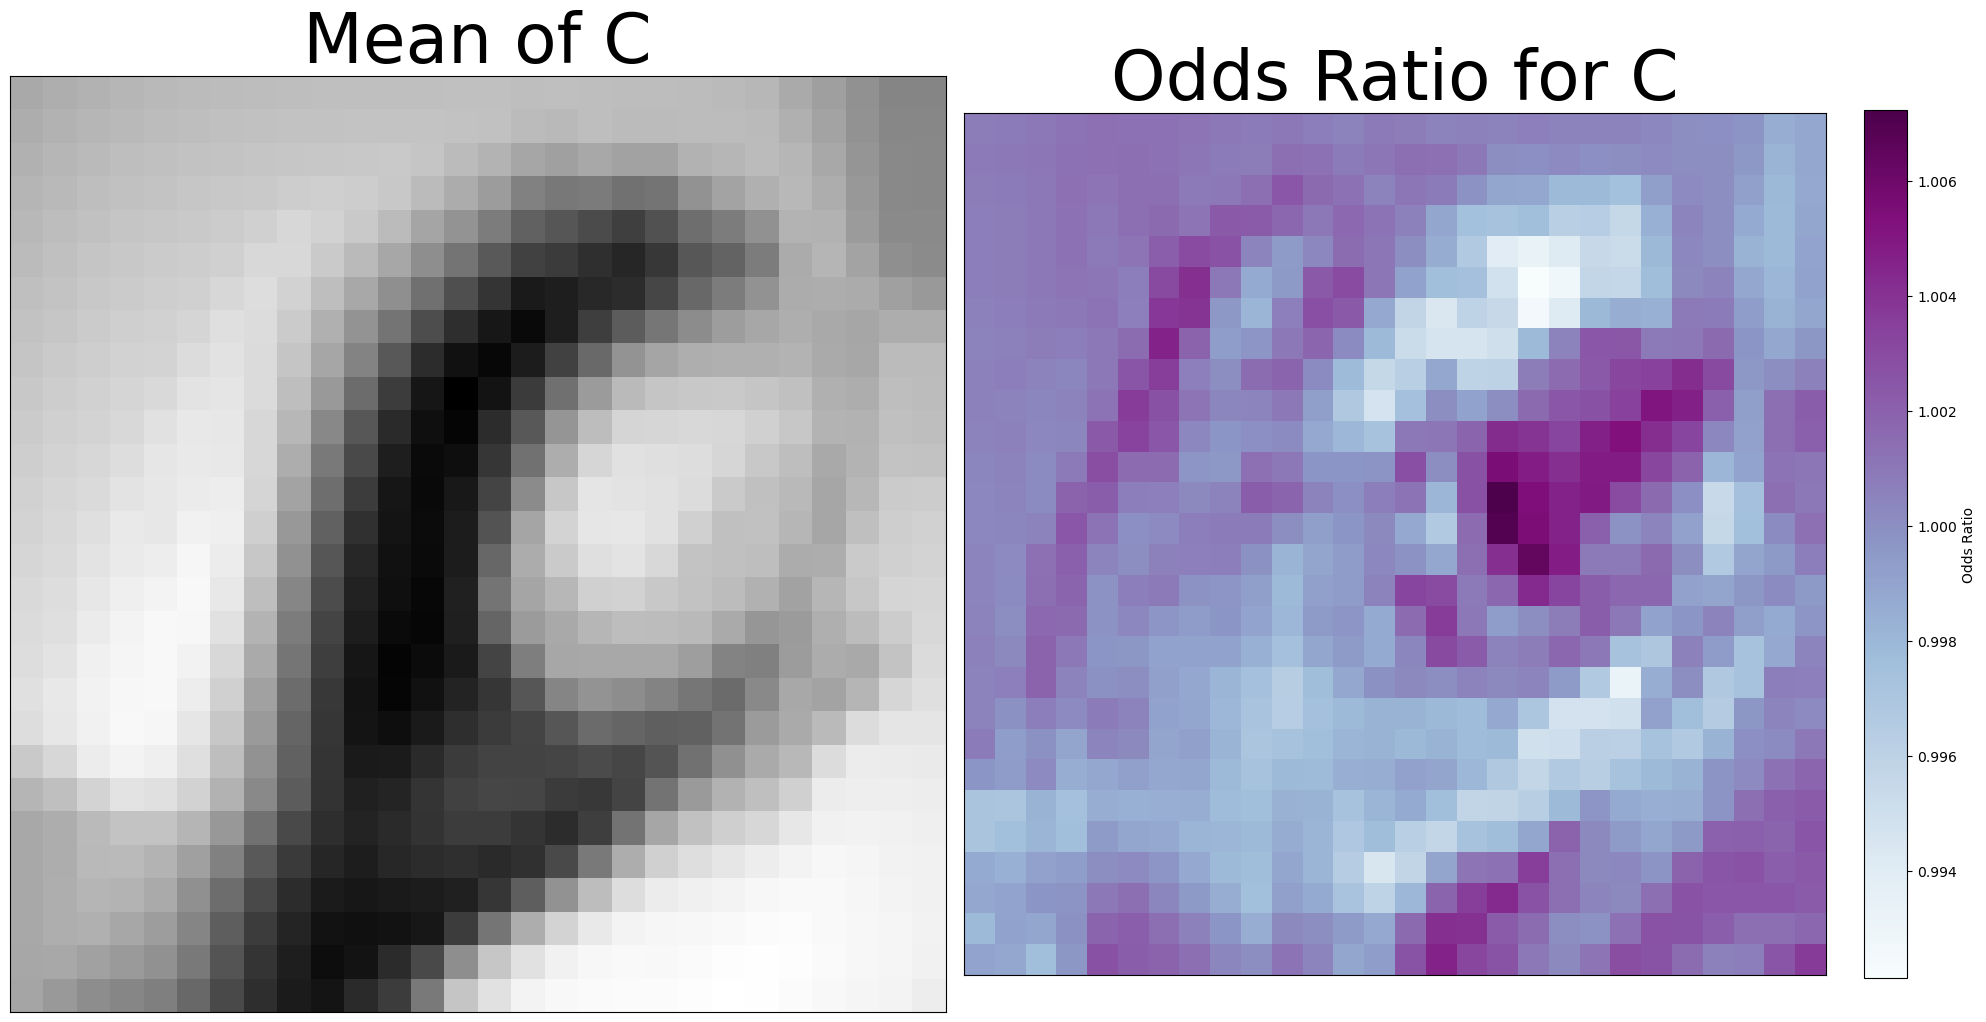

In [25]:
# Getting coefficients again to pass into my new function
letter_coef = my_final_model.coef_
assess_coef(letter_coef,letter='C')

**Comment:** The darker ares in the odds ratio image show pixel intentistites at that particualr location are the most defining for the given letter (in this case A). Areas which are lighter show areas of commonality between the different signs, for example letters A, E, M and N are all similar as they are closed fists with minor differences in finger placement. The odds ratio for these four images would show a slight cross over in locations which are lightest above.

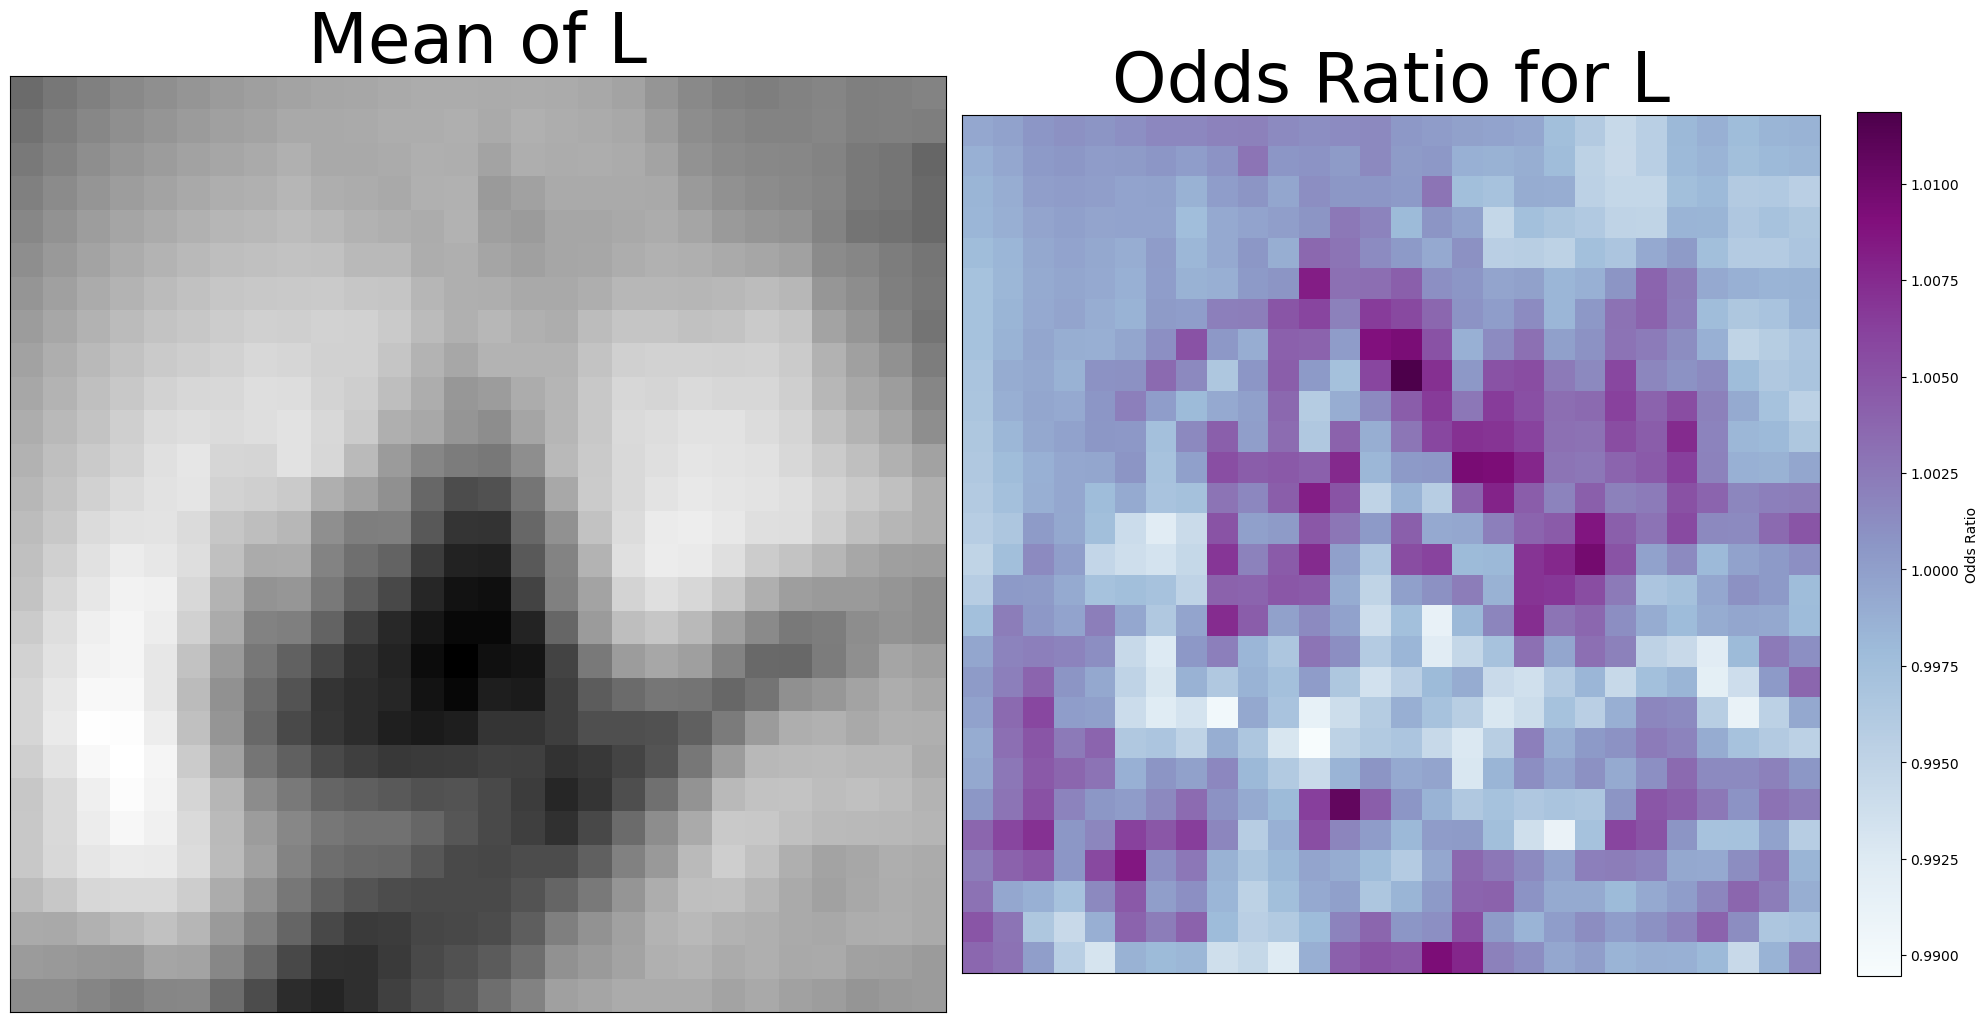

In [26]:
letter_coef = my_final_model.coef_
assess_coef(letter_coef,letter='l')

### Testing an Unseen Input Image

In [35]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '../../data/my_imgs/C.JPG'
input_image = load_img(image_path, target_size=(28, 28))
# Convert image to greyscale
input_image = input_image.convert('L')
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

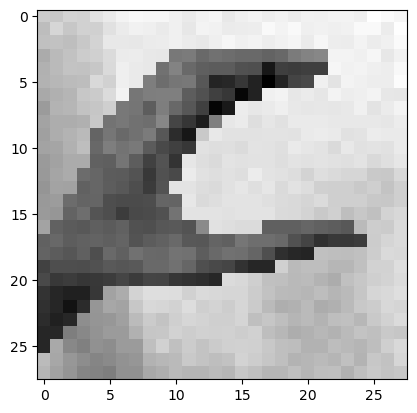

In [36]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [37]:
# Convert the image to a NumPy array
image_array = img_to_array(input_image).astype(float)

In [38]:
# Reshaping to have dimesntions (1,784) -> to match X_train/X_test dimensions
test_img = image_array.reshape(1,28*28)

In [39]:
print(f'Prediction using Logistic Regression: \n{alphabet[my_final_model.predict(test_img)[0]].upper()}')

Prediction using Logistic Regression: 
P


## Conclusion
----

|                  | Logistic Regression Model  |
|------------------|----------------------------|
| Train Score      | 99.99                      |
| Validation Score | 99.99                      |

A basic logistic regression model performed well on the raw MNIST dataset. However there are some reasons why we see a high performance:

- Dataset:
    - MNIST Sign Langauage dataset is a very clean, images are well-structured, centered and uniform which makes it easier for a model to perform classification very well(even simple models like Logistic Regression)
    - If we start to add augmentations and noise to the data, it would be interesting to see if the model accuracy would remain high.

- Linear Model:
    - Logistic Regression is a linear model, it looks to separate out classes with a linear line.
    - Due to the uniformity is MNIST datasets, logistic regression will perform well
    - When data is augmented or noisy like in the real world, classes become less separable meaning there is a need for a non-linear model which have more of a flexible boundary between classes. 

In the following notebooks, we will revisit the baseline logistic regression model built here and see how it performs on augmented data. From the single test image I assume this model will not do very well when the data contains augmenation.


## Appendix
----

In [18]:
my_final_model = joblib.load('../../model/my_models/log_reg_basic_model.pkl')

In [19]:
from sklearn.model_selection import RandomizedSearchCV

In [20]:
# hyperparam training using rand search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10]  # Adjust the range based on your dataset
}

model = LogisticRegression(max_iter=1000, solver='saga')

# Randomised search with cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, verbose=5, random_state = 1, n_jobs = 1)

# Fit randomized search
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ...............C=0.001, penalty=l1;, score=0.042 total time=   4.7s
[CV 2/3] END ...............C=0.001, penalty=l1;, score=0.042 total time=   4.7s
[CV 3/3] END ...............C=0.001, penalty=l1;, score=0.042 total time=   5.9s
[CV 1/3] END ...............C=0.001, penalty=l2;, score=0.591 total time= 1.8min
[CV 2/3] END ...............C=0.001, penalty=l2;, score=0.590 total time= 1.8min
[CV 3/3] END ...............C=0.001, penalty=l2;, score=0.585 total time= 1.8min
[CV 1/3] END ................C=0.01, penalty=l1;, score=0.291 total time=11.4min
[CV 2/3] END ................C=0.01, penalty=l1;, score=0.296 total time=11.4min
[CV 3/3] END ................C=0.01, penalty=l1;, score=0.289 total time=14.6min
[CV 1/3] END ................C=0.01, penalty=l2;, score=0.807 total time= 3.1min
[CV 2/3] END ................C=0.01, penalty=l2;, score=0.800 total time= 3.5min
[CV 3/3] END ................C=0.01, penalty=l2;

/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END .................C=0.1, penalty=l1;, score=0.868 total time=22.7min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END .................C=0.1, penalty=l1;, score=0.872 total time=22.5min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END .................C=0.1, penalty=l1;, score=0.860 total time=22.2min
[CV 1/3] END .................C=0.1, penalty=l2;, score=0.956 total time= 4.7min
[CV 2/3] END .................C=0.1, penalty=l2;, score=0.955 total time=20.6min
[CV 3/3] END .................C=0.1, penalty=l2;, score=0.952 total time= 4.9min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END ...................C=1, penalty=l1;, score=0.998 total time=32.8min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END ...................C=1, penalty=l1;, score=0.996 total time=32.1min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END ...................C=1, penalty=l1;, score=0.998 total time=33.1min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END ..................C=1, penalty=l2;, score=0.999 total time=316.2min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END ..................C=1, penalty=l2;, score=0.997 total time=129.1min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END ...................C=1, penalty=l2;, score=0.999 total time=16.0min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END ..................C=10, penalty=l1;, score=1.000 total time=44.0min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END .................C=10, penalty=l1;, score=0.998 total time=102.9min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END ..................C=10, penalty=l1;, score=1.000 total time=40.5min
[CV 1/3] END ..................C=10, penalty=l2;, score=1.000 total time=88.5min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END ..................C=10, penalty=l2;, score=0.999 total time=23.3min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END ..................C=10, penalty=l2;, score=0.999 total time=16.0min


/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=1000, solver='saga'),
                   n_jobs=1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'penalty': ['l1', 'l2']},
                   random_state=1, verbose=5)

In [27]:
# Viewing best params from rand_search
random_search.best_params_

{'penalty': 'l2', 'C': 10}

In [26]:
random_search.best_estimator_

LogisticRegression(C=10, max_iter=1000, solver='saga')

In [28]:
# saving rand_search as pkl file
joblib.dump(random_search,'../../model/my_models/rand_search.pkl')

['../../model/my_models/rand_search.pkl']